# Compose: Training a model to generate music

In [43]:
import os
import pickle
import numpy
import pydot
from matplotlib import pyplot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras import regularizers

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

## Set parameters

In [76]:
# run params
section = 'compose'
run_id = '0006'
genre_name = 'jazz'
composer_name='ChetBaker'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True
reg = None
#reg = regularizers.l1_l2(l1=0.01,l2=0.01)

## Extract the notes

In [60]:
data_folder

'data/jazz/ChetBaker'

In [63]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)
            #notes.extend(['START'])
            #durations.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

5 files in total
1 Parsing data/jazz/ChetBaker/ChetBaker_ThereWillNeverBeAnotherYou-1_FINAL.mid
2 Parsing data/jazz/ChetBaker/ChetBaker_IFallInLoveTooEasily_FINAL.mid
3 Parsing data/jazz/ChetBaker/ChetBaker_LongAgoAndFarAway_FINAL.mid
4 Parsing data/jazz/ChetBaker/ChetBaker_JustFriends_FINAL.mid
5 Parsing data/jazz/ChetBaker/ChetBaker_ThereWillNeverBeAnotherYou-2_FINAL.mid


In [64]:
print(notes)

['START', 'C5', 'D5', 'C5', 'E5', 'C5', 'D5', 'C5.D5', 'C5', 'E-5', 'C5', 'D5', 'C5', 'B-4', 'F4', 'D4', 'E4', 'G#4', 'G#4.A4', 'A4', 'G#4', 'A4', 'G#4', 'G4', 'F4', 'D4', 'C4', 'F4', 'G#4', 'A4', 'G#4', 'A4', 'C4', 'D4', 'C4', 'D4', 'F4', 'G4', 'A4', 'C5', 'G4', 'F4', 'G4', 'G4', 'A4', 'C5', 'A4', 'G4', 'F4', 'G4', 'A4', 'C5', 'C5.D5', 'D5', 'F5', 'E-5', 'G5', 'F5', 'E-5', 'B4', 'B4', 'D5', 'C#5', 'D5', 'C#5', 'A4', 'C5', 'B4', 'C5', 'C5.D5', 'D5', 'F4', 'F4', 'E-5', 'C#5', 'F4', 'G#4', 'C5', 'B-4', 'C5', 'A4', 'A4.B-4', 'B-4', 'A4', 'G4', 'F4', 'E4', 'D4', 'C#4', 'F4', 'A4', 'B-4', 'A4', 'G4', 'F4', 'D4', 'D4', 'D4', 'D4', 'E4', 'F4', 'A4', 'A4', 'A4', 'G#4.A4', 'G#4', 'F4', 'G4', 'C4', 'D4', 'E4', 'E4.F4', 'F4', 'E4', 'D4', 'C4', 'D4', 'D4', 'D4', 'D4', 'E4', 'F4', 'E4.F4', 'E4', 'F4', 'E4', 'D4', 'E4', 'C#4', 'E4', 'G4', 'A4', 'B-4', 'A4', 'B-4', 'A4', 'C4.A4', 'C4', 'D4', 'A4', 'G#4', 'G4', 'G4', 'F4', 'G4', 'F4', 'G4', 'F4', 'G4', 'F4', 'G4', 'F4', 'G#4', 'F4', 'G#4', 'F4', 'G4',

## Create the lookup tables

In [65]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
#velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
#velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [66]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A3': 0,
 'A3.E-4': 1,
 'A4': 2,
 'A4.B-4': 3,
 'B-3': 4,
 'B-3.E-4': 5,
 'B-4': 6,
 'B-4.C5': 7,
 'B-4.D5': 8,
 'B3': 9,
 'B3.C#4': 10,
 'B3.E-4': 11,
 'B4': 12,
 'B4.C5': 13,
 'B4.D5': 14,
 'B4.E-5': 15,
 'C#4': 16,
 'C#4.D4': 17,
 'C#5': 18,
 'C4': 19,
 'C4.A4': 20,
 'C4.C#4': 21,
 'C4.D4': 22,
 'C4.E-4': 23,
 'C4.F#4': 24,
 'C5': 25,
 'C5.C#5': 26,
 'C5.D5': 27,
 'D4': 28,
 'D4.E-4': 29,
 'D4.E4': 30,
 'D5': 31,
 'D5.E-5': 32,
 'D5.E5': 33,
 'D5.F5': 34,
 'E-4': 35,
 'E-4.E4': 36,
 'E-4.F4': 37,
 'E-4.G4': 38,
 'E-5': 39,
 'E-5.F5': 40,
 'E4': 41,
 'E4.F#4': 42,
 'E4.F4': 43,
 'E5': 44,
 'E5.F#5': 45,
 'E5.F5': 46,
 'F#4': 47,
 'F#4.A4': 48,
 'F#4.E-5': 49,
 'F#4.G4': 50,
 'F#5': 51,
 'F#5.G5': 52,
 'F4': 53,
 'F4.G4': 54,
 'F5': 55,
 'F5.F#5': 56,
 'F5.G5': 57,
 'G#4': 58,
 'G#4.A4': 59,
 'G#4.B4': 60,
 'G#5': 61,
 'G3': 62,
 'G3.A3': 63,
 'G4': 64,
 'G4.A4': 65,
 'G4.B-4': 66,
 'G4.B4': 67,
 'G4.G#4': 68,
 'G5': 69,
 'G5.G#5': 70,
 'START': 71}

In [67]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 Fraction(13, 12): 13,
 Fraction(7, 6): 14,
 1.25: 15,
 Fraction(4, 3): 16,
 1.5: 17,
 Fraction(5, 3): 18,
 2.0: 19,
 2.25: 20,
 Fraction(7, 3): 21,
 2.5: 22,
 Fraction(8, 3): 23,
 5.5: 24}

## Prepare the sequences used by the Neural Network

In [68]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [69]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[71 25 31 25 44 25 31 27 25 39 25 31 25  6 53 28 41 58 59  2 58  2 58 64
 53 28 19 53 58  2 58  2]
duration input
[0 6 6 6 6 4 4 2 2 6 3 6 6 6 4 6 4 6 2 1 4 3 4 6 6 6 3 9 8 6 6 6]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
duration output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


## Create the structure of the neural network

In [77]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention, reg)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, None, 100)    7200        input_9[0][0]                    
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, None, 100)    2500        input_10[0][0]                   
____________________________________________________________________________________________

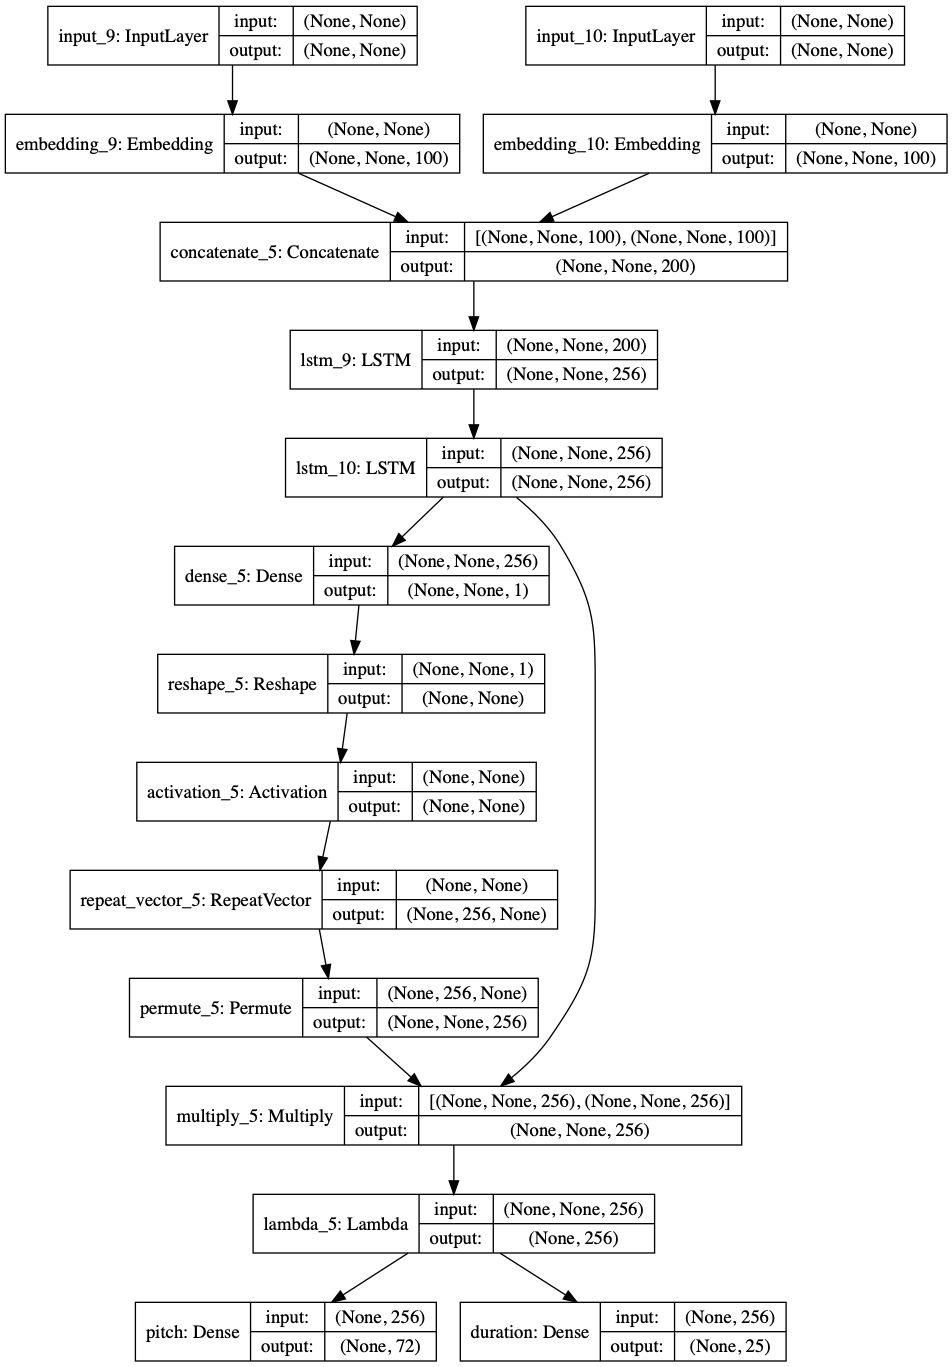

In [78]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [79]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [81]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
history = model.fit(network_input, network_output
          , epochs=20000, batch_size=64
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

train_history = history.history['loss']
val_history = history.history['val_loss']


Train on 419 samples, validate on 419 samples
Epoch 1/20000
419/419 [==============================] - 3s 7ms/step - loss: 14.2668 - pitch_loss: 3.1978 - duration_loss: 2.1139 - val_loss: 14.6621 - val_pitch_loss: 3.4340 - val_duration_loss: 2.2805
Epoch 2/20000
419/419 [==============================] - 3s 8ms/step - loss: 14.1208 - pitch_loss: 3.2007 - duration_loss: 2.1130 - val_loss: 14.5335 - val_pitch_loss: 3.4197 - val_duration_loss: 2.2760
Epoch 3/20000
419/419 [==============================] - 3s 8ms/step - loss: 13.9701 - pitch_loss: 3.1493 - duration_loss: 2.0858 - val_loss: 14.4898 - val_pitch_loss: 3.4887 - val_duration_loss: 2.2541
Epoch 4/20000
419/419 [==============================] - 4s 9ms/step - loss: 13.8517 - pitch_loss: 3.1093 - duration_loss: 2.0927 - val_loss: 14.4621 - val_pitch_loss: 3.4866 - val_duration_loss: 2.3334
Epoch 5/20000
419/419 [==============================] - 3s 8ms/step - loss: 13.7471 - pitch_loss: 3.1218 - duration_loss: 2.0575 - val_loss: 

Epoch 41/20000
419/419 [==============================] - 4s 9ms/step - loss: 9.1369 - pitch_loss: 2.2032 - duration_loss: 1.5888 - val_loss: 13.3601 - val_pitch_loss: 4.9502 - val_duration_loss: 3.0985
Epoch 42/20000
419/419 [==============================] - 3s 8ms/step - loss: 9.2160 - pitch_loss: 2.2648 - duration_loss: 1.6720 - val_loss: 13.0089 - val_pitch_loss: 4.9167 - val_duration_loss: 2.8186
Epoch 43/20000
419/419 [==============================] - 3s 7ms/step - loss: 8.9659 - pitch_loss: 2.1776 - duration_loss: 1.6024 - val_loss: 13.1363 - val_pitch_loss: 4.9528 - val_duration_loss: 3.0263
Epoch 44/20000
419/419 [==============================] - 3s 8ms/step - loss: 8.9533 - pitch_loss: 2.2028 - duration_loss: 1.6532 - val_loss: 12.9169 - val_pitch_loss: 4.9813 - val_duration_loss: 2.8553
Epoch 45/20000
419/419 [==============================] - 3s 7ms/step - loss: 8.8302 - pitch_loss: 2.1653 - duration_loss: 1.6352 - val_loss: 12.9099 - val_pitch_loss: 4.9966 - val_duratio

419/419 [==============================] - 3s 8ms/step - loss: 4.8870 - pitch_loss: 1.3716 - duration_loss: 1.0202 - val_loss: 12.0235 - val_pitch_loss: 5.8701 - val_duration_loss: 3.6929
Epoch 82/20000
419/419 [==============================] - 4s 8ms/step - loss: 4.9927 - pitch_loss: 1.4285 - duration_loss: 1.0899 - val_loss: 11.8609 - val_pitch_loss: 5.9468 - val_duration_loss: 3.4725
Epoch 83/20000
419/419 [==============================] - 3s 8ms/step - loss: 4.7382 - pitch_loss: 1.2875 - duration_loss: 1.0219 - val_loss: 11.9712 - val_pitch_loss: 5.9601 - val_duration_loss: 3.6124
Epoch 84/20000
419/419 [==============================] - 4s 9ms/step - loss: 4.7377 - pitch_loss: 1.3841 - duration_loss: 1.0708 - val_loss: 11.7623 - val_pitch_loss: 5.9045 - val_duration_loss: 3.5518
Epoch 85/20000
419/419 [==============================] - 3s 8ms/step - loss: 4.5275 - pitch_loss: 1.2863 - duration_loss: 0.9523 - val_loss: 11.8893 - val_pitch_loss: 6.0329 - val_duration_loss: 3.5724


419/419 [==============================] - 3s 8ms/step - loss: 1.8119 - pitch_loss: 0.7174 - duration_loss: 0.5716 - val_loss: 11.6672 - val_pitch_loss: 6.8599 - val_duration_loss: 4.3102
Epoch 122/20000
419/419 [==============================] - 3s 8ms/step - loss: 1.4561 - pitch_loss: 0.5601 - duration_loss: 0.4085 - val_loss: 11.4570 - val_pitch_loss: 6.7187 - val_duration_loss: 4.2534
Epoch 123/20000
419/419 [==============================] - 3s 8ms/step - loss: 1.7409 - pitch_loss: 0.7010 - duration_loss: 0.5633 - val_loss: 11.5150 - val_pitch_loss: 6.7434 - val_duration_loss: 4.3578
Epoch 124/20000
419/419 [==============================] - 3s 8ms/step - loss: 1.3423 - pitch_loss: 0.5182 - duration_loss: 0.3886 - val_loss: 11.5364 - val_pitch_loss: 6.7157 - val_duration_loss: 4.4627
Epoch 125/20000
419/419 [==============================] - 3s 8ms/step - loss: 1.5895 - pitch_loss: 0.6668 - duration_loss: 0.5219 - val_loss: 11.4944 - val_pitch_loss: 6.7367 - val_duration_loss: 4.4

419/419 [==============================] - 4s 8ms/step - loss: 0.3642 - pitch_loss: 0.2078 - duration_loss: 0.1448 - val_loss: 12.3456 - val_pitch_loss: 7.3817 - val_duration_loss: 4.9507
Epoch 162/20000
419/419 [==============================] - 4s 9ms/step - loss: 0.4779 - pitch_loss: 0.2933 - duration_loss: 0.1948 - val_loss: 12.5263 - val_pitch_loss: 7.4547 - val_duration_loss: 5.0574
Epoch 163/20000
419/419 [==============================] - 3s 8ms/step - loss: 0.7149 - pitch_loss: 0.3882 - duration_loss: 0.3283 - val_loss: 12.1479 - val_pitch_loss: 7.2582 - val_duration_loss: 4.8435
Epoch 164/20000
419/419 [==============================] - 3s 7ms/step - loss: 0.6837 - pitch_loss: 0.3630 - duration_loss: 0.3006 - val_loss: 12.3819 - val_pitch_loss: 7.3142 - val_duration_loss: 5.0593
Epoch 165/20000
419/419 [==============================] - 3s 8ms/step - loss: 0.4688 - pitch_loss: 0.2658 - duration_loss: 0.1981 - val_loss: 12.1333 - val_pitch_loss: 7.3542 - val_duration_loss: 4.7

KeyboardInterrupt: 

In [ ]:
pyplot.plot(train_history, color='blue', label='train')
pyplot.plot(val_history, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower left')
pyplot.show()